# Zad 11 - `Zadanie LSTM`

**Temat:** Algorytm LSTM dla tekstu

 ## **Treść zadania**

Opracować sieć LSTM w celu nauczenia się tekstu z dokładnością 0.1

**Wariant zadania: `14`**

Tekst do nauczenia: `As machines become increasingly capable, tasks considered to require "intelligence" are often removed from the definition of AI, a phenomenon known as the AI effect`

### Kod Python

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import signal

plt.style.use('seaborn-v0_8-white')

# =================== Dane wejściowe ===================
data = """As machines become increasingly capable, tasks considered to require "intelligence" are often removed from the definition of AI, a phenomenon known as the AI effect"""

# Przetwarzanie danych
chars = list(set(data))
data_size, X_size = len(data), len(chars)
print("data has %d characters, %d unique" % (data_size, X_size))
char_to_idx = {ch: i for i, ch in enumerate(chars)}
idx_to_char = {i: ch for i, ch in enumerate(chars)}

# =================== Hiperparametry ===================
H_size = 20           # Rozmiar warstwy ukrytej (zwiększono dla lepszej zbieżności)
T_steps = 25          # Liczba kroków czasowych (długość sekwencji treningowej)
learning_rate = 1e-1  # Szybkość uczenia
weight_sd = 0.1       # Odchylenie standardowe inicjalizacji wag
z_size = H_size + X_size  # Rozmiar wektora konkatenacji [h, x]

# =================== Funkcje aktywacji ===================
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def dsigmoid(y):
    return y * (1 - y)

def tanh(x):
    return np.tanh(x)

def dtanh(y):
    return 1 - y * y

# =================== Parametry modelu ===================
class Param:
    def __init__(self, name, value):
        self.name = name
        self.v = value        # wartość parametru
        self.d = np.zeros_like(value)  # gradient
        self.m = np.zeros_like(value)  # moment dla AdaGrad

class Parameters:
    def __init__(self):
        self.W_f = Param('W_f', np.random.randn(H_size, z_size) * weight_sd + 0.5)
        self.b_f = Param('b_f', np.zeros((H_size, 1)))
        self.W_i = Param('W_i', np.random.randn(H_size, z_size) * weight_sd + 0.5)
        self.b_i = Param('b_i', np.zeros((H_size, 1)))
        self.W_C = Param('W_C', np.random.randn(H_size, z_size) * weight_sd)
        self.b_C = Param('b_C', np.zeros((H_size, 1)))
        self.W_o = Param('W_o', np.random.randn(H_size, z_size) * weight_sd + 0.5)
        self.b_o = Param('b_o', np.zeros((H_size, 1)))
        self.W_v = Param('W_v', np.random.randn(X_size, H_size) * weight_sd)
        self.b_v = Param('b_v', np.zeros((X_size, 1)))

    def all(self):
        return [self.W_f, self.W_i, self.W_C, self.W_o, self.W_v,
                self.b_f, self.b_i, self.b_C, self.b_o, self.b_v]

parameters = Parameters()

# =================== Forward pass ===================
def forward(x, h_prev, C_prev):
    z = np.row_stack((h_prev, x))
    f = sigmoid(np.dot(parameters.W_f.v, z) + parameters.b_f.v)
    i = sigmoid(np.dot(parameters.W_i.v, z) + parameters.b_i.v)
    C_bar = tanh(np.dot(parameters.W_C.v, z) + parameters.b_C.v)
    C = f * C_prev + i * C_bar
    o = sigmoid(np.dot(parameters.W_o.v, z) + parameters.b_o.v)
    h = o * tanh(C)
    v = np.dot(parameters.W_v.v, h) + parameters.b_v.v
    y = np.exp(v) / np.sum(np.exp(v))  # softmax
    return z, f, i, C_bar, C, o, h, v, y

# =================== Backward pass ===================
def backward(target, dh_next, dC_next, C_prev, z, f, i, C_bar, C, o, h, v, y):
    dv = np.copy(y)
    dv[target] -= 1  # pochodna cross-entropy z softmax
    parameters.W_v.d += np.dot(dv, h.T)
    parameters.b_v.d += dv

    dh = np.dot(parameters.W_v.v.T, dv)
    dh += dh_next

    do = dh * tanh(C)
    do = dsigmoid(o) * do
    parameters.W_o.d += np.dot(do, z.T)
    parameters.b_o.d += do

    dC = dh * o * dtanh(tanh(C))
    dC += dC_next

    dC_bar = dC * i
    dC_bar = dtanh(C_bar) * dC_bar
    parameters.W_C.d += np.dot(dC_bar, z.T)
    parameters.b_C.d += dC_bar

    di = dC * C_bar
    di = dsigmoid(i) * di
    parameters.W_i.d += np.dot(di, z.T)
    parameters.b_i.d += di

    df = dC * C_prev
    df = dsigmoid(f) * df
    parameters.W_f.d += np.dot(df, z.T)
    parameters.b_f.d += df

    dz = (np.dot(parameters.W_f.v.T, df) +
          np.dot(parameters.W_i.v.T, di) +
          np.dot(parameters.W_C.v.T, dC_bar) +
          np.dot(parameters.W_o.v.T, do))
    dh_prev = dz[:H_size, :]
    dC_prev = f * dC
    return dh_prev, dC_prev

# =================== Narzędzia pomocnicze ===================
def clear_gradients():
    for p in parameters.all():
        p.d.fill(0)

def clip_gradients():
    for p in parameters.all():
        np.clip(p.d, -1, 1, out=p.d)

def forward_backward(inputs, targets, h_prev, C_prev):
    x_s, z_s, f_s, i_s = {}, {}, {}, {}
    C_bar_s, C_s, o_s, h_s, v_s, y_s = {}, {}, {}, {}, {}, {}

    h_s[-1] = np.copy(h_prev)
    C_s[-1] = np.copy(C_prev)
    loss = 0

    # Forward
    for t in range(len(inputs)):
        x_s[t] = np.zeros((X_size, 1))
        x_s[t][inputs[t]] = 1
        z_s[t], f_s[t], i_s[t], C_bar_s[t], C_s[t], o_s[t], h_s[t], v_s[t], y_s[t] = forward(x_s[t], h_s[t-1], C_s[t-1])
        loss += -np.log(y_s[t][targets[t], 0])

    clear_gradients()
    dh_next = np.zeros_like(h_s[0])
    dC_next = np.zeros_like(C_s[0])

    # Backward
    for t in reversed(range(len(inputs))):
        dh_next, dC_next = backward(targets[t], dh_next, dC_next, C_s[t-1],
                                    z_s[t], f_s[t], i_s[t], C_bar_s[t], C_s[t], o_s[t], h_s[t], v_s[t], y_s[t])

    clip_gradients()
    return loss, h_s[len(inputs)-1], C_s[len(inputs)-1]

def sample(h_prev, C_prev, first_char_idx, sentence_length):
    x = np.zeros((X_size, 1))
    x[first_char_idx] = 1
    h = h_prev
    C = C_prev
    indexes = []
    for _ in range(sentence_length):
        _, _, _, _, C, _, h, _, y = forward(x, h, C)
        idx = np.random.choice(range(X_size), p=y.ravel())
        x = np.zeros((X_size, 1))
        x[idx] = 1
        indexes.append(idx)
    return indexes

def update_status(inputs, h_prev, C_prev, iteration, smooth_loss):
    sample_idx = sample(h_prev, C_prev, inputs[0], 200)
    txt = ''.join(idx_to_char[idx] for idx in sample_idx)
    display.clear_output(wait=True)
    print("---\n %s \n---" % txt)
    print("iter %d, loss %f" % (iteration, smooth_loss))

def update_parameters():
    for p in parameters.all():
        p.m += p.d * p.d
        p.v -= learning_rate * p.d / np.sqrt(p.m + 1e-8)

class DelayedKeyboardInterrupt:
    def __enter__(self):
        self.signal_received = False
        self.old_handler = signal.signal(signal.SIGINT, self.handler)
        return self
    def handler(self, sig, frame):
        self.signal_received = (sig, frame)
        print('SIGINT received. Delaying KeyboardInterrupt.')
    def __exit__(self, type, value, traceback):
        signal.signal(signal.SIGINT, self.old_handler)
        if self.signal_received:
            self.old_handler(*self.signal_received)

# =================== Trenowanie ===================
smooth_loss = -np.log(1.0 / X_size) * T_steps
iteration, pointer = 0, 0
plot_iter, plot_loss = [], []

# Inicjalizacja stanów ukrytych
h_prev = np.zeros((H_size, 1))
C_prev = np.zeros((H_size, 1))

print("Rozpoczynam trenowanie...")
try:
    with DelayedKeyboardInterrupt():
        while smooth_loss >= 0.1:  # Warunek stopu: loss < 0.1
            if pointer + T_steps >= len(data):
                h_prev = np.zeros((H_size, 1))
                C_prev = np.zeros((H_size, 1))
                pointer = 0

            inputs = [char_to_idx[ch] for ch in data[pointer:pointer + T_steps]]
            targets = [char_to_idx[ch] for ch in data[pointer + 1:pointer + T_steps + 1]]

            loss, h_prev, C_prev = forward_backward(inputs, targets, h_prev, C_prev)
            smooth_loss = smooth_loss * 0.999 + loss * 0.001

            if iteration % 100 == 0:
                update_status(inputs, h_prev, C_prev, iteration, smooth_loss)

            update_parameters()
            plot_iter.append(iteration)
            plot_loss.append(loss)

            pointer += T_steps
            iteration += 1
except KeyboardInterrupt:
    pass

print("Trening zakończony!")
update_status(inputs, h_prev, C_prev, iteration, smooth_loss)

---
 icsecoin oftos removed from the definition of AI, a phenomenon known as romoved from the definition of AI, a phenomenon known as AI, a pon, the ton of ov dof AI, caphychfromerof AI, a phenomeron kngen 
---
iter 8481, loss 0.099991


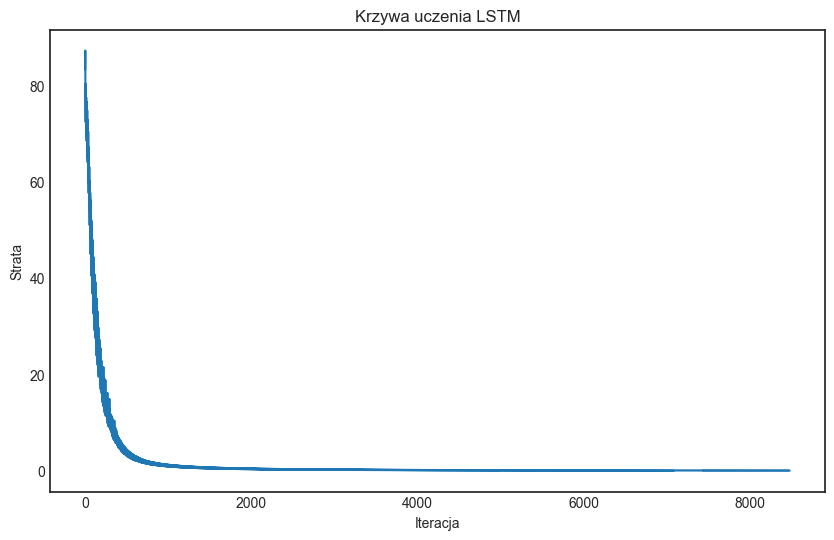

In [2]:

# Wykres straty
plt.figure(figsize=(10, 6))
plt.plot(plot_iter, plot_loss)
plt.xlabel('Iteracja')
plt.ylabel('Strata')
plt.title('Krzywa uczenia LSTM')
plt.show()